In [98]:
# notebook dependencies
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import os # for caching purposeses
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plotly module/library
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# regular expression import
import re

# JSON import
import json

# importing BeautifulSoup for parsing HTML/XTML
from bs4 import BeautifulSoup

# request module for connecting to APIs
from requests import get

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from pprint import pprint

In [81]:
# obtain subreddit text data 

def get_reddit_stress():
    # cached filename to look for
    filename = "stress.csv"

    # search for filename in local/OS directory
    if os.path.isfile(filename):

        # if file and filename exists, then return csv as Pandas df
        # future iteration: consider using relative path 
        # this may help to prevent referencing deleted/incorrect files
        df = pd.read_csv(filename, index_col = "social_timestamp")

        # print df shape
        print(f'dataframe shape: {df.shape}')

        # return the dataframe
        return df

    # if file/csv can't be found in OS directory, then access the data and cache it as a csv locally
    else:

        url = "https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv"
        # read text data as csv and convert to pandas dataframe
        df = pd.read_csv(url)

        # let's move forward with just the following columns/features
        df = df[[
            "label", 
            "post_id",
            "subreddit",                                 
            "sentence_range",              
            "text",                        
            "id",              
            "confidence",            
            "social_timestamp",           
            "social_karma",                
            "syntax_ari",
            "sentiment",
            "social_upvote_ratio",
            "social_num_comments"
            ]]

        # timestamp appears to be in "epoch seconds format"
        df["social_timestamp"] = pd.to_datetime(df['social_timestamp'], unit = 's')

        # sort and set data as index
        df.set_index('social_timestamp', inplace = True)

        # cache the data for easier/quicker reference
        df.to_csv("stress.csv")

        # print the shape
        print(f'dataframe shape: {df.shape}')

        # return the dataframe
        return df

In [82]:
# testing out the created function 

df = get_reddit_stress()
df.head()

dataframe shape: (2838, 12)


,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments
social_timestamp,,,,,,,,,,,,
2018-03-21 06:39:13,1,8601tu,ptsd,"(15, 20)","He said he had not felt that way before, sugge...",33181,0.8,5,1.806818,-0.002742,0.86,1
2018-05-22 17:23:37,0,8lbrx9,assistance,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,1.0,4,9.429737,0.292857,0.65,2
2018-09-03 00:46:45,1,9ch1zh,ptsd,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,0.8,2,7.769821,0.011894,0.67,0
2018-01-20 06:25:55,1,7rorpp,relationships,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,0.6,0,2.667798,0.141671,0.50,5
2018-10-17 20:43:25,1,9p2gbc,survivorsofabuse,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,0.8,24,7.554238,-0.204167,1.00,1


In [83]:
# df info

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2838 entries, 2018-03-21 06:39:13 to 2017-03-07 17:58:36
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                2838 non-null   int64  
 1   post_id              2838 non-null   object 
 2   subreddit            2838 non-null   object 
 3   sentence_range       2838 non-null   object 
 4   text                 2838 non-null   object 
 5   id                   2838 non-null   int64  
 6   confidence           2838 non-null   float64
 7   social_karma         2838 non-null   int64  
 8   syntax_ari           2838 non-null   float64
 9   sentiment            2838 non-null   float64
 10  social_upvote_ratio  2838 non-null   float64
 11  social_num_comments  2838 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 288.2+ KB


In [84]:
# df shape

df.shape

(2838, 12)

In [85]:
# column names to list

df.columns.tolist()

['label',
 'post_id',
 'subreddit',
 'sentence_range',
 'text',
 'id',
 'confidence',
 'social_karma',
 'syntax_ari',
 'sentiment',
 'social_upvote_ratio',
 'social_num_comments']

In [86]:
# what is the percentage of missing values by ea. column/feature?

with pd.option_context("display.max_rows", False):
    print(df.isnull().mean()) # no features contain missing values

label                  0.0
post_id                0.0
subreddit              0.0
sentence_range         0.0
text                   0.0
id                     0.0
confidence             0.0
social_karma           0.0
syntax_ari             0.0
sentiment              0.0
social_upvote_ratio    0.0
social_num_comments    0.0
dtype: float64


In [87]:
# # let's move forward with the following columns/features

# df = df[[
#     "label", 
#     "post_id",
#     "subreddit",                                 
#     "sentence_range",              
#     "text",                        
#     "id",              
#     "confidence",            
#     "social_timestamp",           
#     "social_karma",                
#     "syntax_ari",
#     "sentiment",
#     "social_upvote_ratio",
#     "social_num_comments"
#     ]]

# df.shape 

In [88]:
# cache text data as csv for easier accessing

# df.to_csv("stress.csv")

In [89]:
# check the head

# df = pd.read_csv("stress.csv", index_col = True)

In [90]:
# let's look at the "social_timestamp" feature 
# timestamp appears to be in "epoch seconds format"

# df["social_timestamp"] = pd.to_datetime(df['social_timestamp'], unit = 's')
# df["social_timestamp"].head() # checks out!

In [91]:
# check the df info

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2838 entries, 2018-03-21 06:39:13 to 2017-03-07 17:58:36
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                2838 non-null   int64  
 1   post_id              2838 non-null   object 
 2   subreddit            2838 non-null   object 
 3   sentence_range       2838 non-null   object 
 4   text                 2838 non-null   object 
 5   id                   2838 non-null   int64  
 6   confidence           2838 non-null   float64
 7   social_karma         2838 non-null   int64  
 8   syntax_ari           2838 non-null   float64
 9   sentiment            2838 non-null   float64
 10  social_upvote_ratio  2838 non-null   float64
 11  social_num_comments  2838 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 288.2+ KB


In [92]:
# set timestamp as index

# df = df.set_index(pd.DatetimeIndex(df['social_timestamp']))
# df.head()

In [93]:
# check the head

df.head()

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments
social_timestamp,,,,,,,,,,,,
2018-03-21 06:39:13,1,8601tu,ptsd,"(15, 20)","He said he had not felt that way before, sugge...",33181,0.8,5,1.806818,-0.002742,0.86,1
2018-05-22 17:23:37,0,8lbrx9,assistance,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,1.0,4,9.429737,0.292857,0.65,2
2018-09-03 00:46:45,1,9ch1zh,ptsd,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,0.8,2,7.769821,0.011894,0.67,0
2018-01-20 06:25:55,1,7rorpp,relationships,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,0.6,0,2.667798,0.141671,0.50,5
2018-10-17 20:43:25,1,9p2gbc,survivorsofabuse,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,0.8,24,7.554238,-0.204167,1.00,1


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2838 entries, 2018-03-21 06:39:13 to 2017-03-07 17:58:36
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                2838 non-null   int64  
 1   post_id              2838 non-null   object 
 2   subreddit            2838 non-null   object 
 3   sentence_range       2838 non-null   object 
 4   text                 2838 non-null   object 
 5   id                   2838 non-null   int64  
 6   confidence           2838 non-null   float64
 7   social_karma         2838 non-null   int64  
 8   syntax_ari           2838 non-null   float64
 9   sentiment            2838 non-null   float64
 10  social_upvote_ratio  2838 non-null   float64
 11  social_num_comments  2838 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 288.2+ KB


In [95]:
# data familiarization/exploration 
# let's look at ea. individual feature/column and their respective values

for col in df.columns:
    if col != "text":
        print(f'feature name: {col}')
        print(f'data type: {df[col].dtype}')
        print(f'number of unique values: {df[col].nunique()}')
        print(f'value samples: {df[col].sample(10).unique()}')
        print()

feature name: label
data type: int64
number of unique values: 2
value samples: [1 0]

feature name: post_id
data type: object
number of unique values: 2343
value samples: ['7q4w6l' '7prwnl' '9b66ly' '9kegfm' '9t5tc9' '61eiq6' '8cprrd' '8fo9w0'
 '8cqq8m' '5n56lm']

feature name: subreddit
data type: object
number of unique values: 10
value samples: ['relationships' 'homeless' 'ptsd' 'anxiety' 'survivorsofabuse'
 'assistance']

feature name: sentence_range
data type: object
number of unique values: 173
value samples: ['[20, 25]' '[0, 5]' '[5, 10]' '(3, 8)' '[75, 80]' '(20, 25)' '(40, 45)'
 '(0, 5)']

feature name: id
data type: int64
number of unique values: 2838
value samples: [ 1759   653  1099 36226  1100  1004 23073 28090 34744  1348]

feature name: confidence
data type: float64
number of unique values: 10
value samples: [1.         0.6        0.85714286 0.57142857 0.83333333 0.8       ]

feature name: social_karma
data type: int64
number of unique values: 135
value samples: [ 6 10  

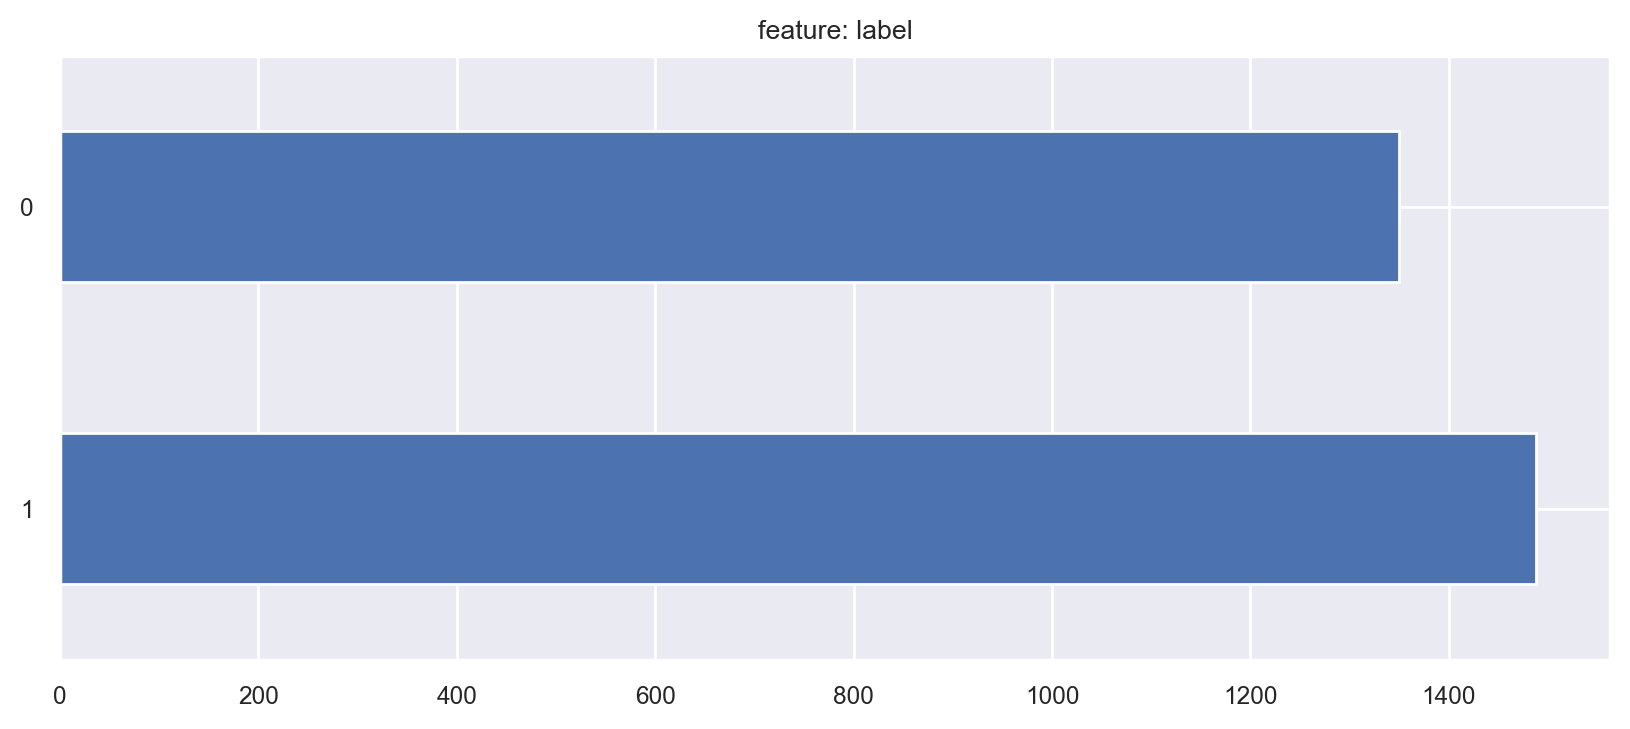

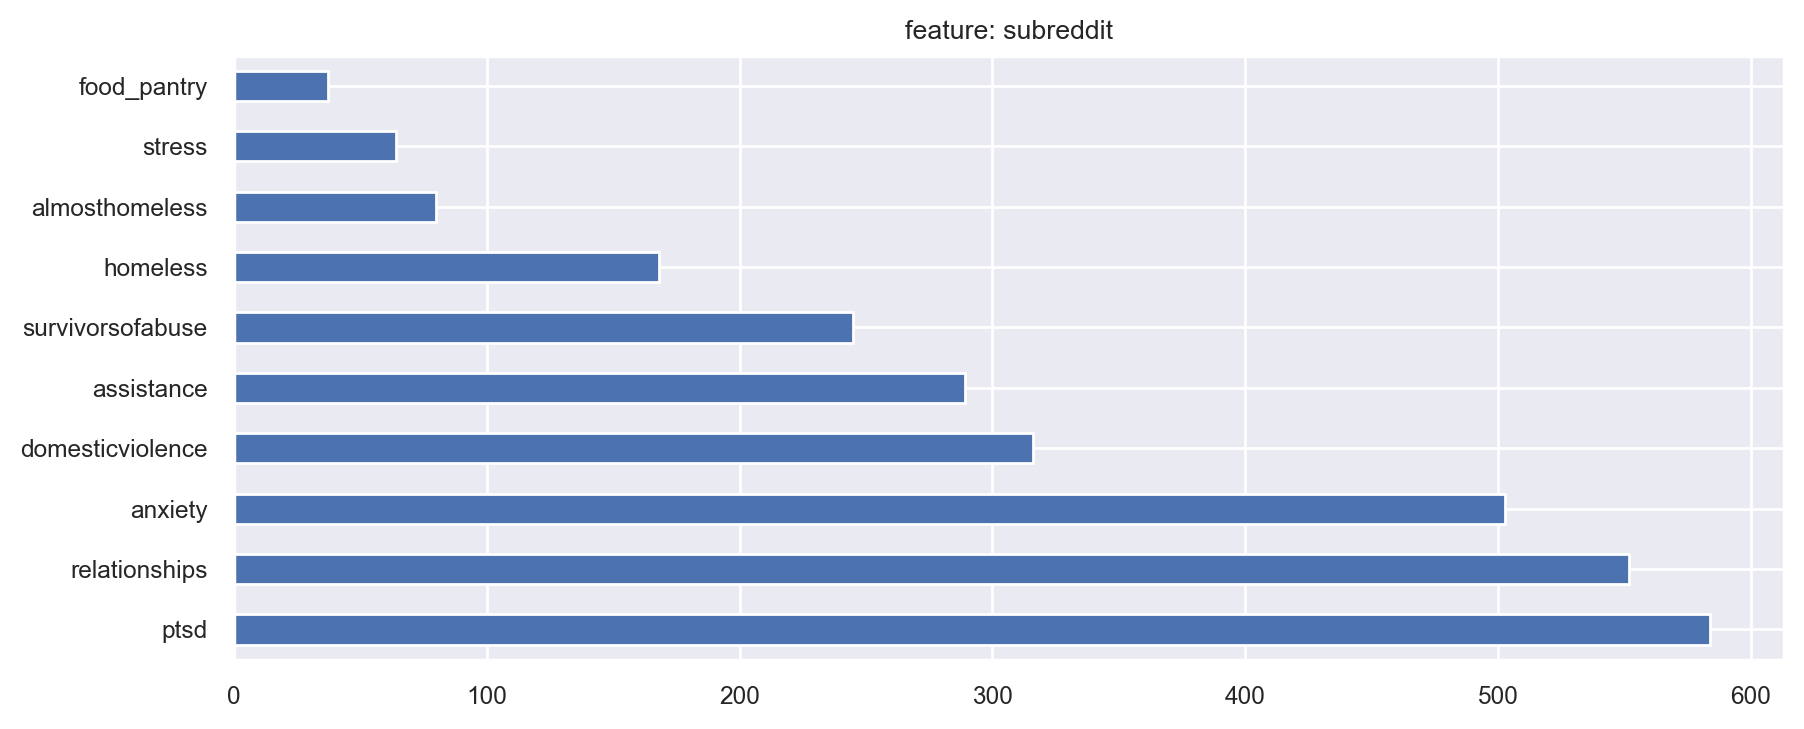

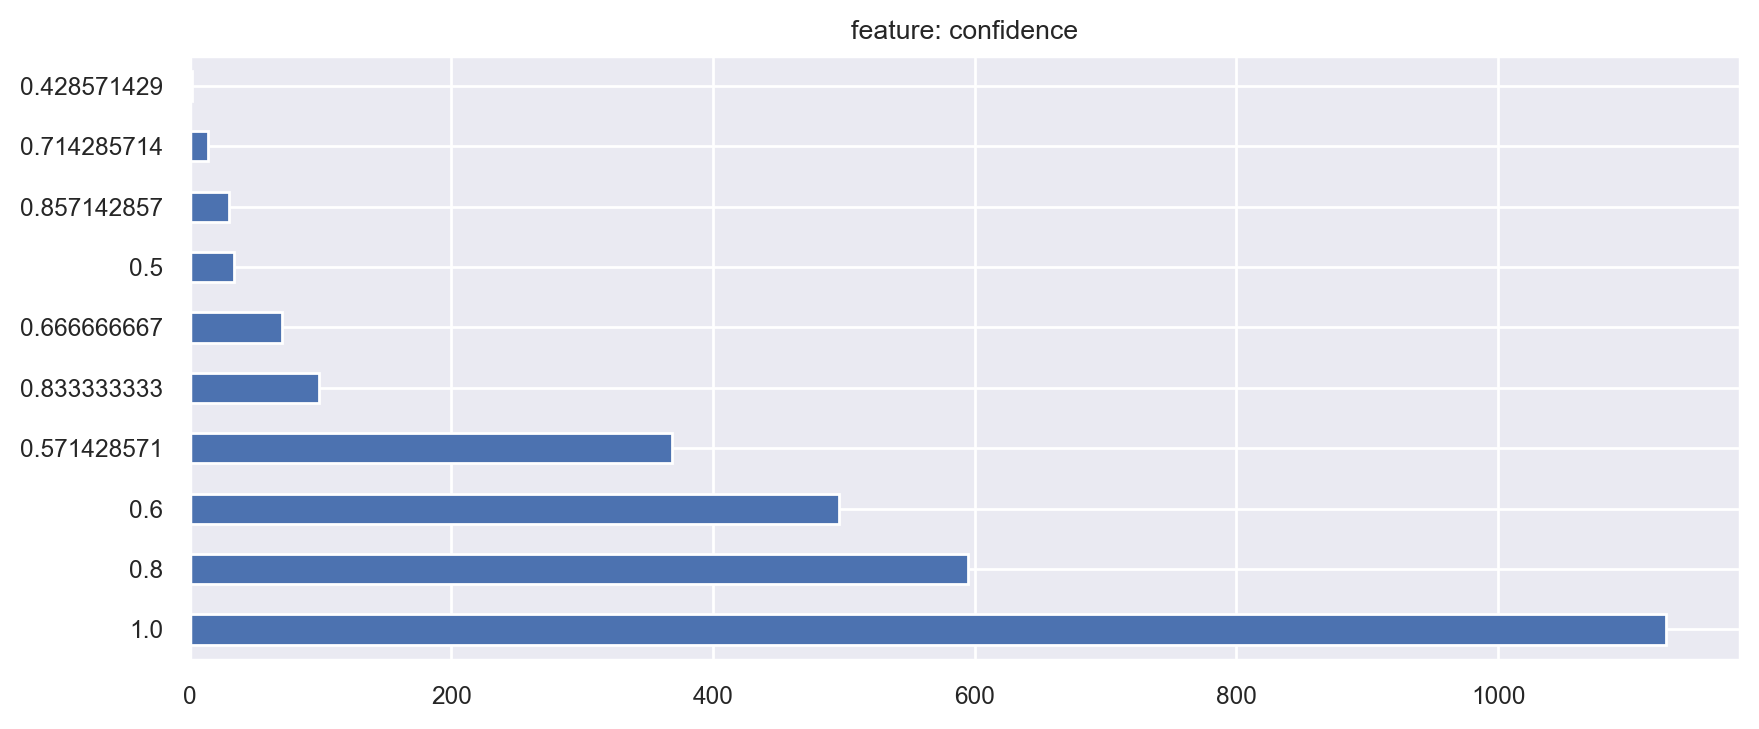

In [97]:
# let's plot a by column value counts

for col in df.columns:
    if df[col].nunique() <= 25:
        plt.figure(figsize = (10,4))
        sns.set(font_scale = 0.8)

        df[col].value_counts().plot(kind = "barh")

        plt.title(f'feature: {col}')
        plt.show()

### ``what about subreddit topics over time?``

In [99]:
# let's first look at the time span 
# viewing latest date first

df.index.max()

'2018-11-19 01:54:20'

In [100]:
# earliest date

df.index.min()

'2017-01-01 12:36:58'

In [106]:
# creating a month and year column 

df['month_year'] = pd.to_datetime(df.index).to_period('M')
df.head()

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments,month_year
social_timestamp,,,,,,,,,,,,,
2018-03-21 06:39:13,1,8601tu,ptsd,"(15, 20)","He said he had not felt that way before, sugge...",33181,0.8,5,1.806818,-0.002742,0.86,1,2018-03
2018-05-22 17:23:37,0,8lbrx9,assistance,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,1.0,4,9.429737,0.292857,0.65,2,2018-05
2018-09-03 00:46:45,1,9ch1zh,ptsd,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,0.8,2,7.769821,0.011894,0.67,0,2018-09
2018-01-20 06:25:55,1,7rorpp,relationships,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,0.6,0,2.667798,0.141671,0.50,5,2018-01
2018-10-17 20:43:25,1,9p2gbc,survivorsofabuse,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,0.8,24,7.554238,-0.204167,1.00,1,2018-10


In [107]:
# sort df by index timestamp

df = df.sort_index(ascending = True)
df.head()

,label,post_id,subreddit,sentence_range,text,id,confidence,social_karma,syntax_ari,sentiment,social_upvote_ratio,social_num_comments,month_year
social_timestamp,,,,,,,,,,,,,
2017-01-01 12:36:58,1,5lezhz,domesticviolence,"[14, 19]",He came after me a few times so I got away and...,313,0.571429,4,0.531035,0.076333,0.84,3,2017-01
2017-01-01 12:36:58,1,5lezhz,domesticviolence,"(5, 10)","We will get through this and I am determined, ...",31536,0.857143,4,8.679730,0.047222,0.84,3,2017-01
2017-01-01 18:35:06,1,5lge1y,anxiety,"(0, 5)",Currently in s constant state of anxiety with ...,7419,1.000000,14,7.822923,-0.083333,0.94,8,2017-01
2017-01-03 16:10:28,1,5lspep,survivorsofabuse,"(5, 10)",I was having a fucking panic attack.Once we pa...,18404,1.000000,5,0.633660,-0.466667,0.86,7,2017-01
2017-01-03 22:13:10,1,5luwz3,almosthomeless,"[10, 15]",I am afraid that she will sell the house becau...,1804,0.800000,5,2.823077,-0.401250,0.65,15,2017-01


In [168]:
# plotting subreddit topics over time

test_df = pd.get_dummies(df["subreddit"])
test_df.index = pd.to_datetime(test_df.index)
test_df.head()

,almosthomeless,anxiety,assistance,domesticviolence,food_pantry,homeless,ptsd,relationships,stress,survivorsofabuse
social_timestamp,,,,,,,,,,
2017-01-01 12:36:58,0,0,0,1,0,0,0,0,0,0
2017-01-01 12:36:58,0,0,0,1,0,0,0,0,0,0
2017-01-01 18:35:06,0,1,0,0,0,0,0,0,0,0
2017-01-03 16:10:28,0,0,0,0,0,0,0,0,0,1
2017-01-03 22:13:10,1,0,0,0,0,0,0,0,0,0


In [198]:
# create a list of subreddit column/feature names

test_cols = test_df.columns.tolist()
test_cols

['almosthomeless',
 'anxiety',
 'assistance',
 'domesticviolence',
 'food_pantry',
 'homeless',
 'ptsd',
 'relationships',
 'stress',
 'survivorsofabuse']

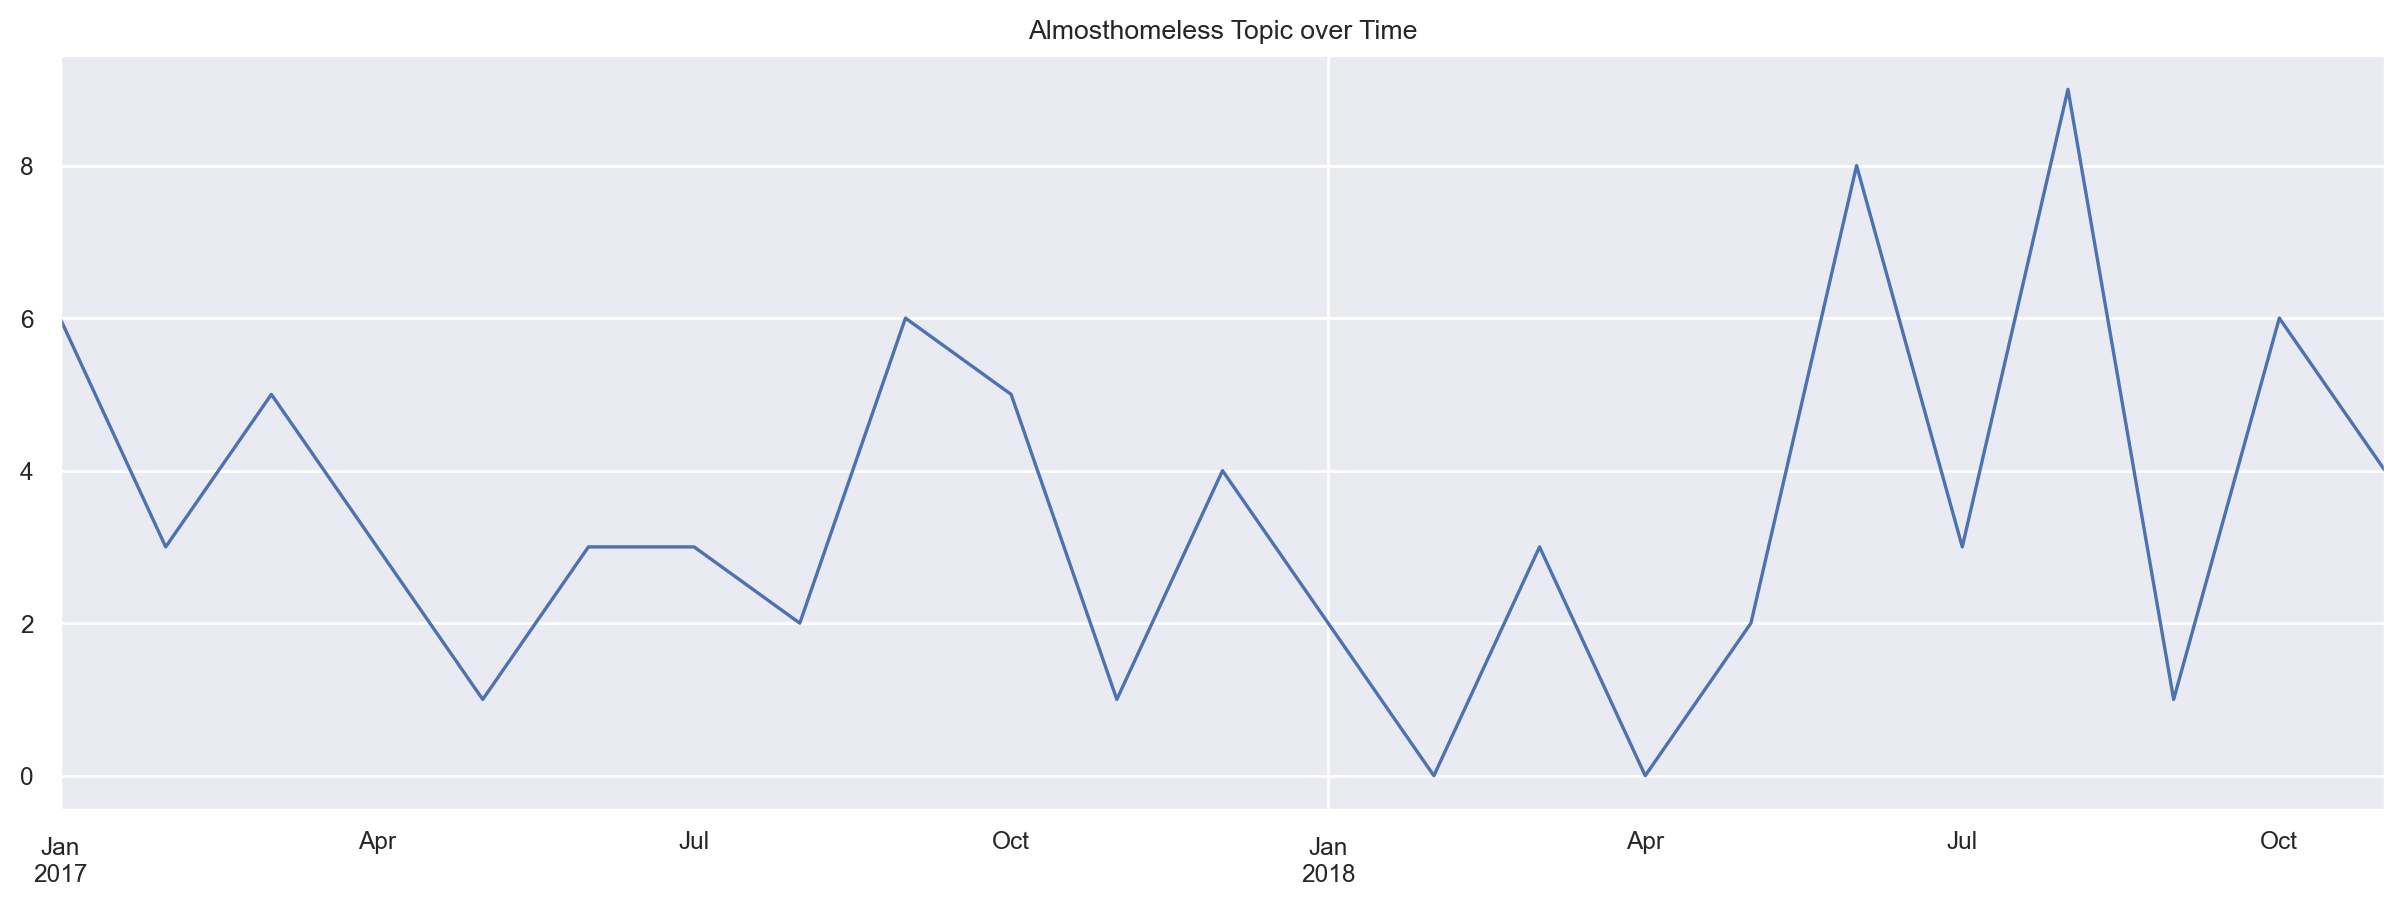

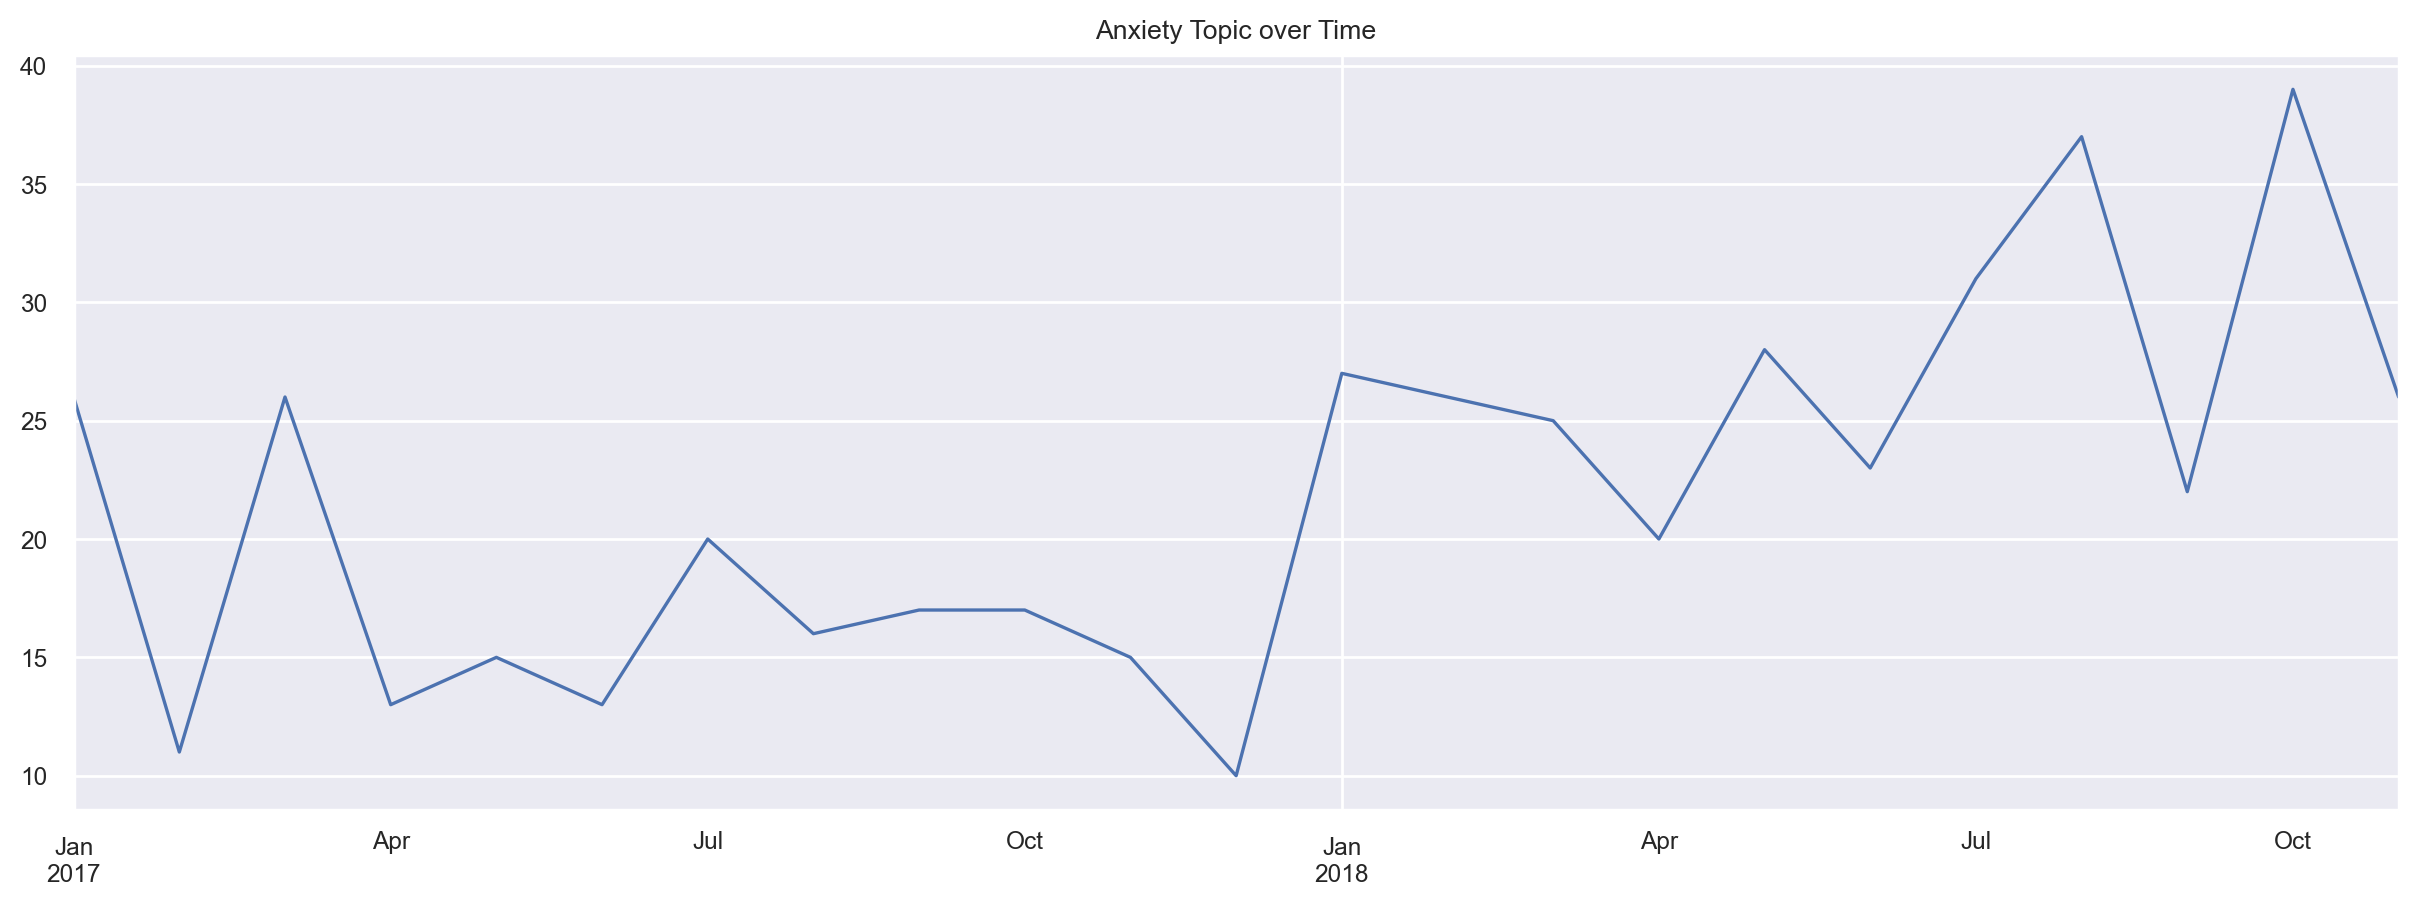

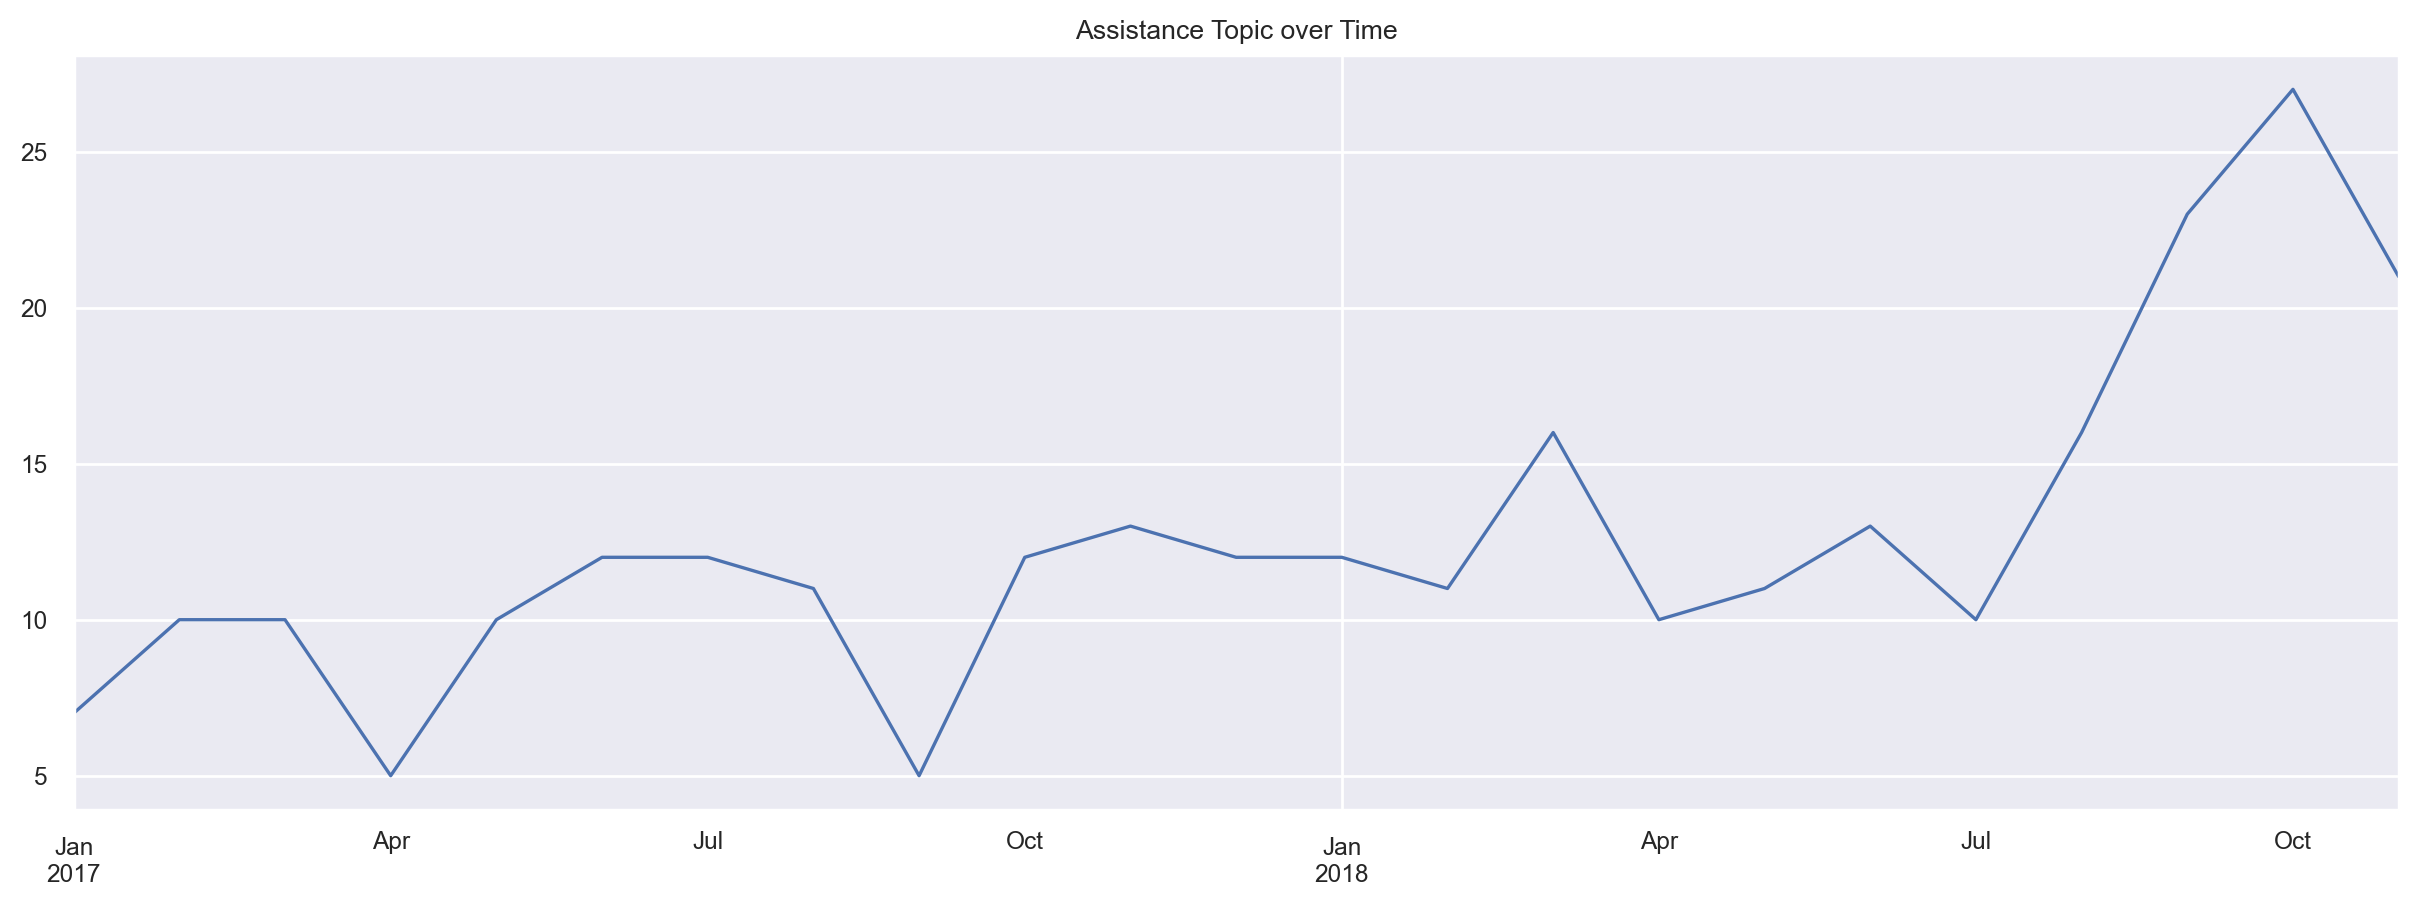

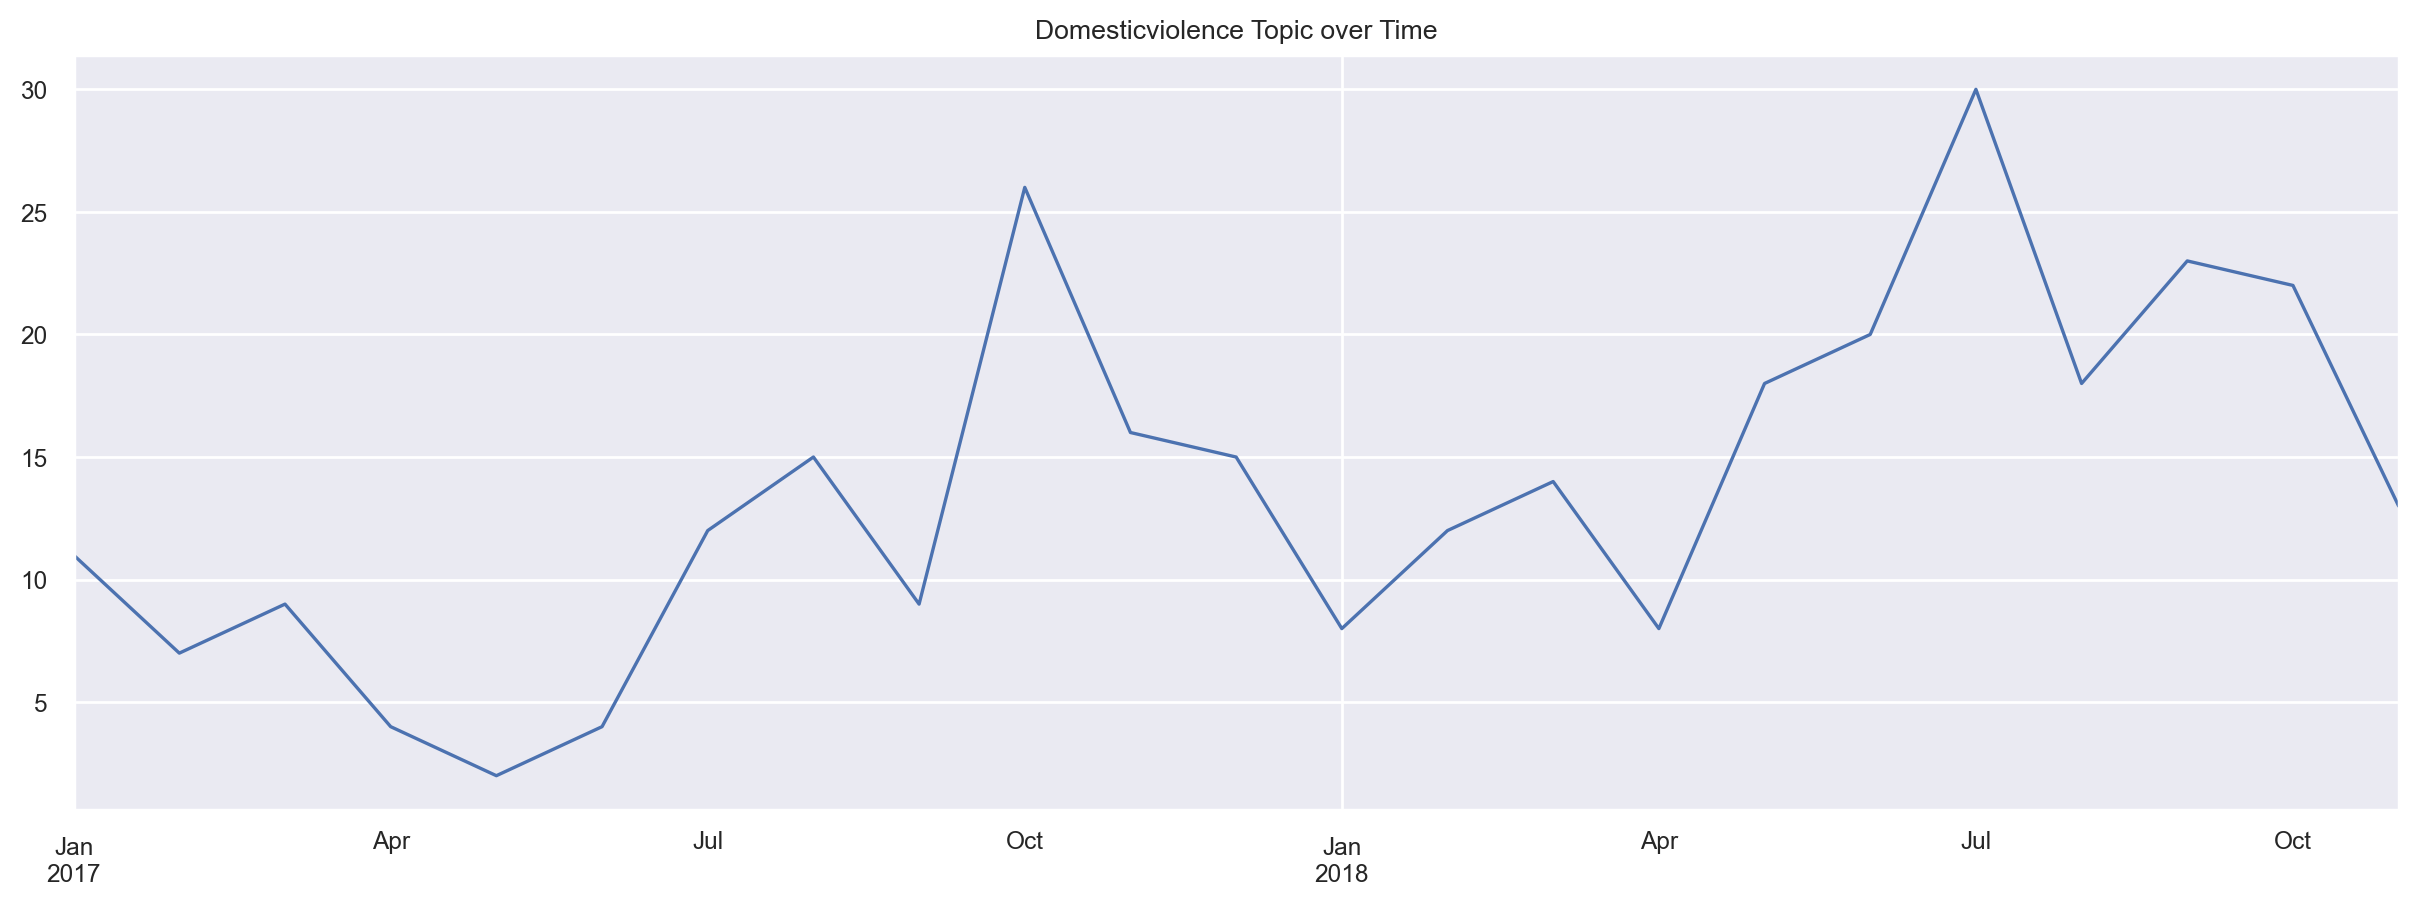

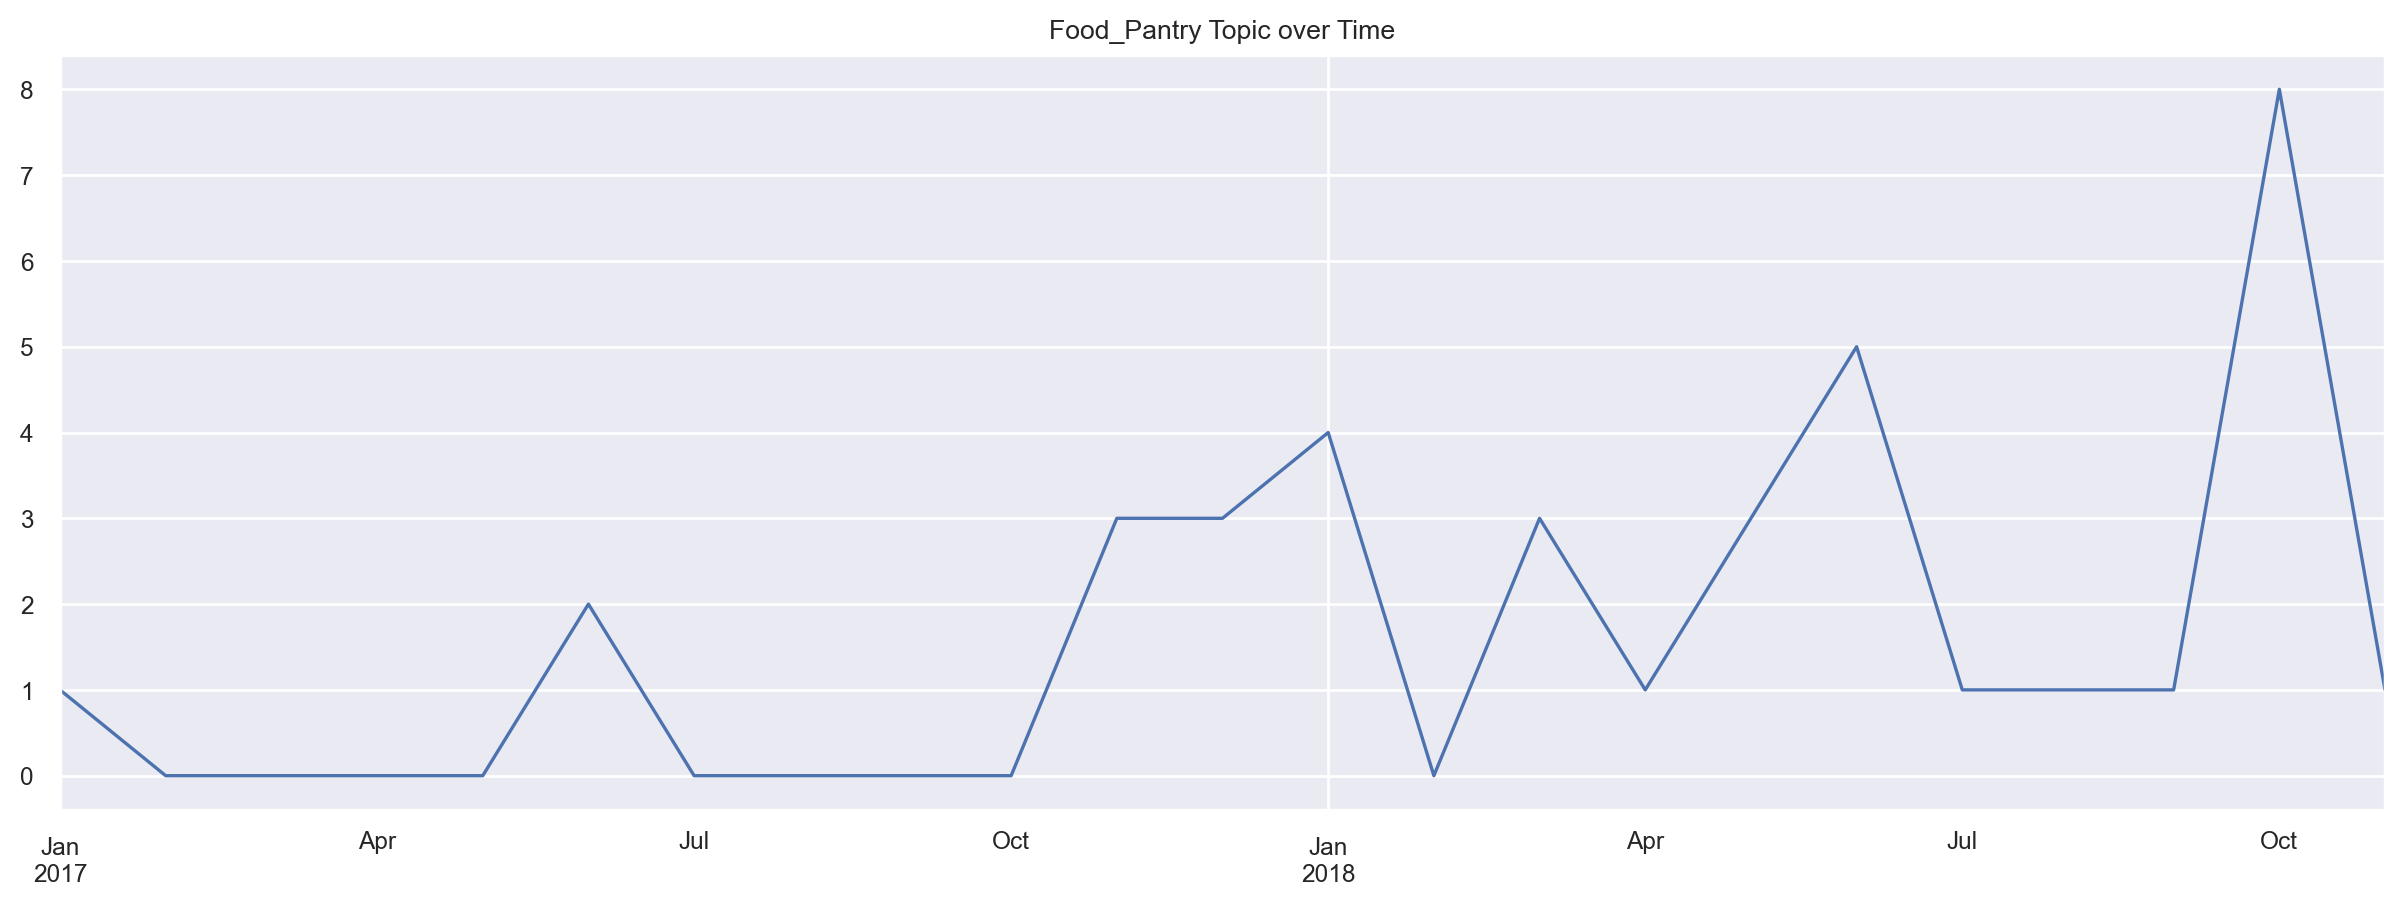

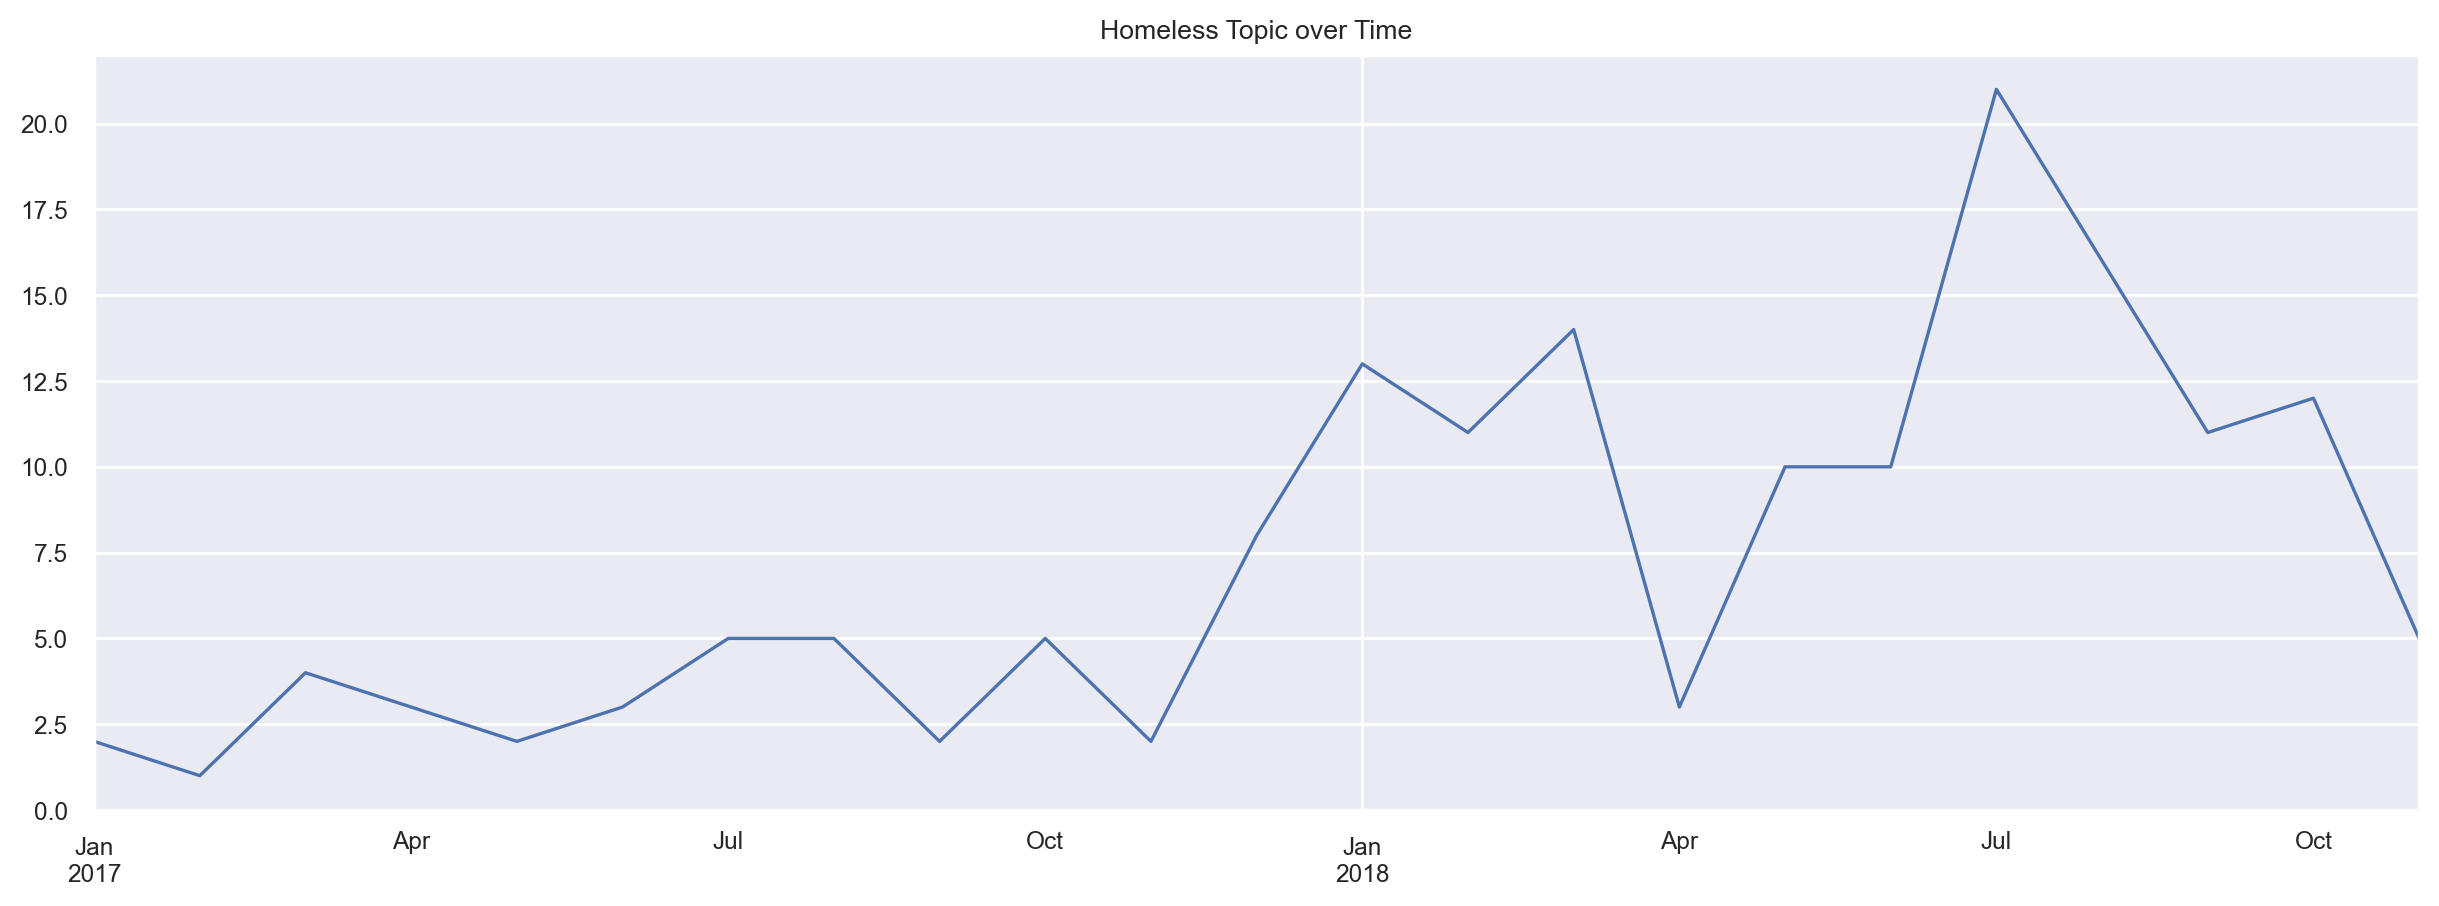

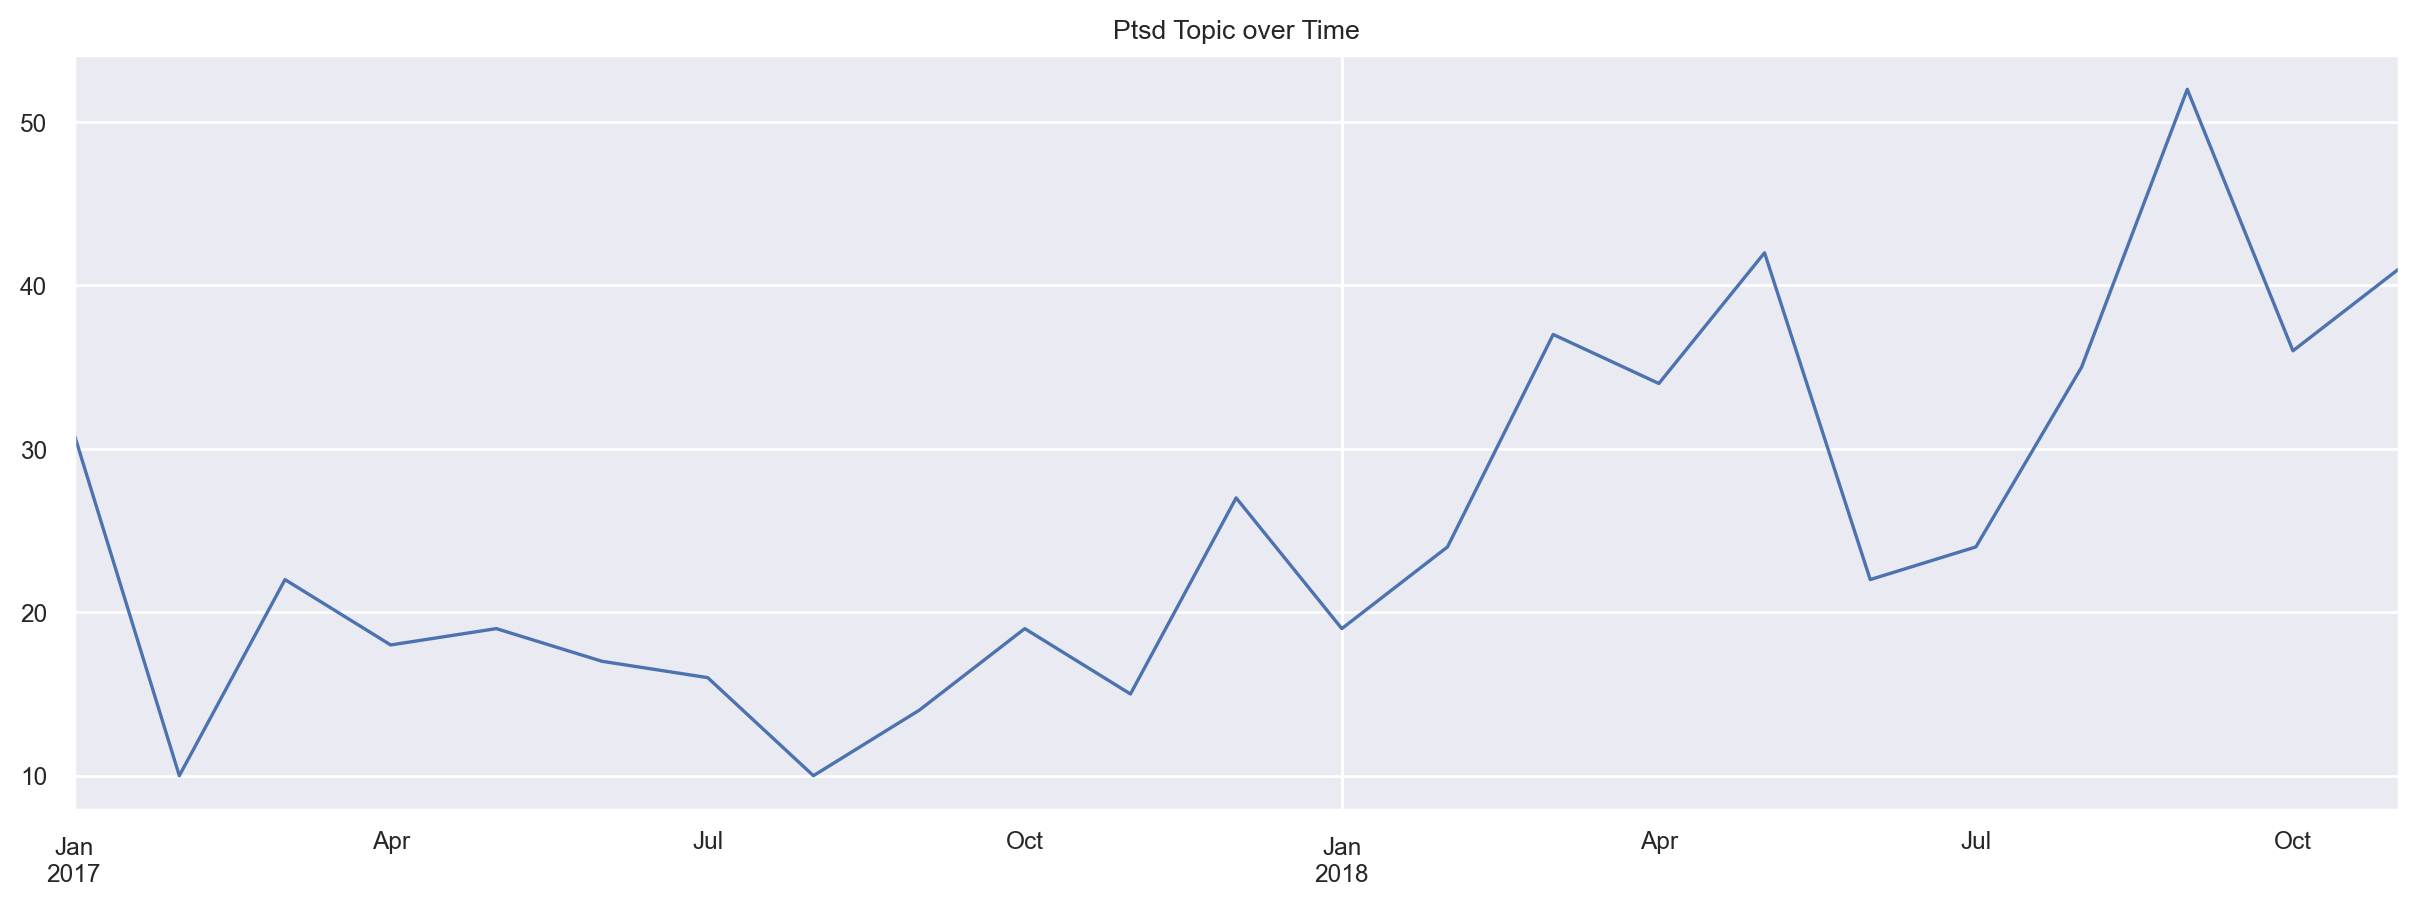

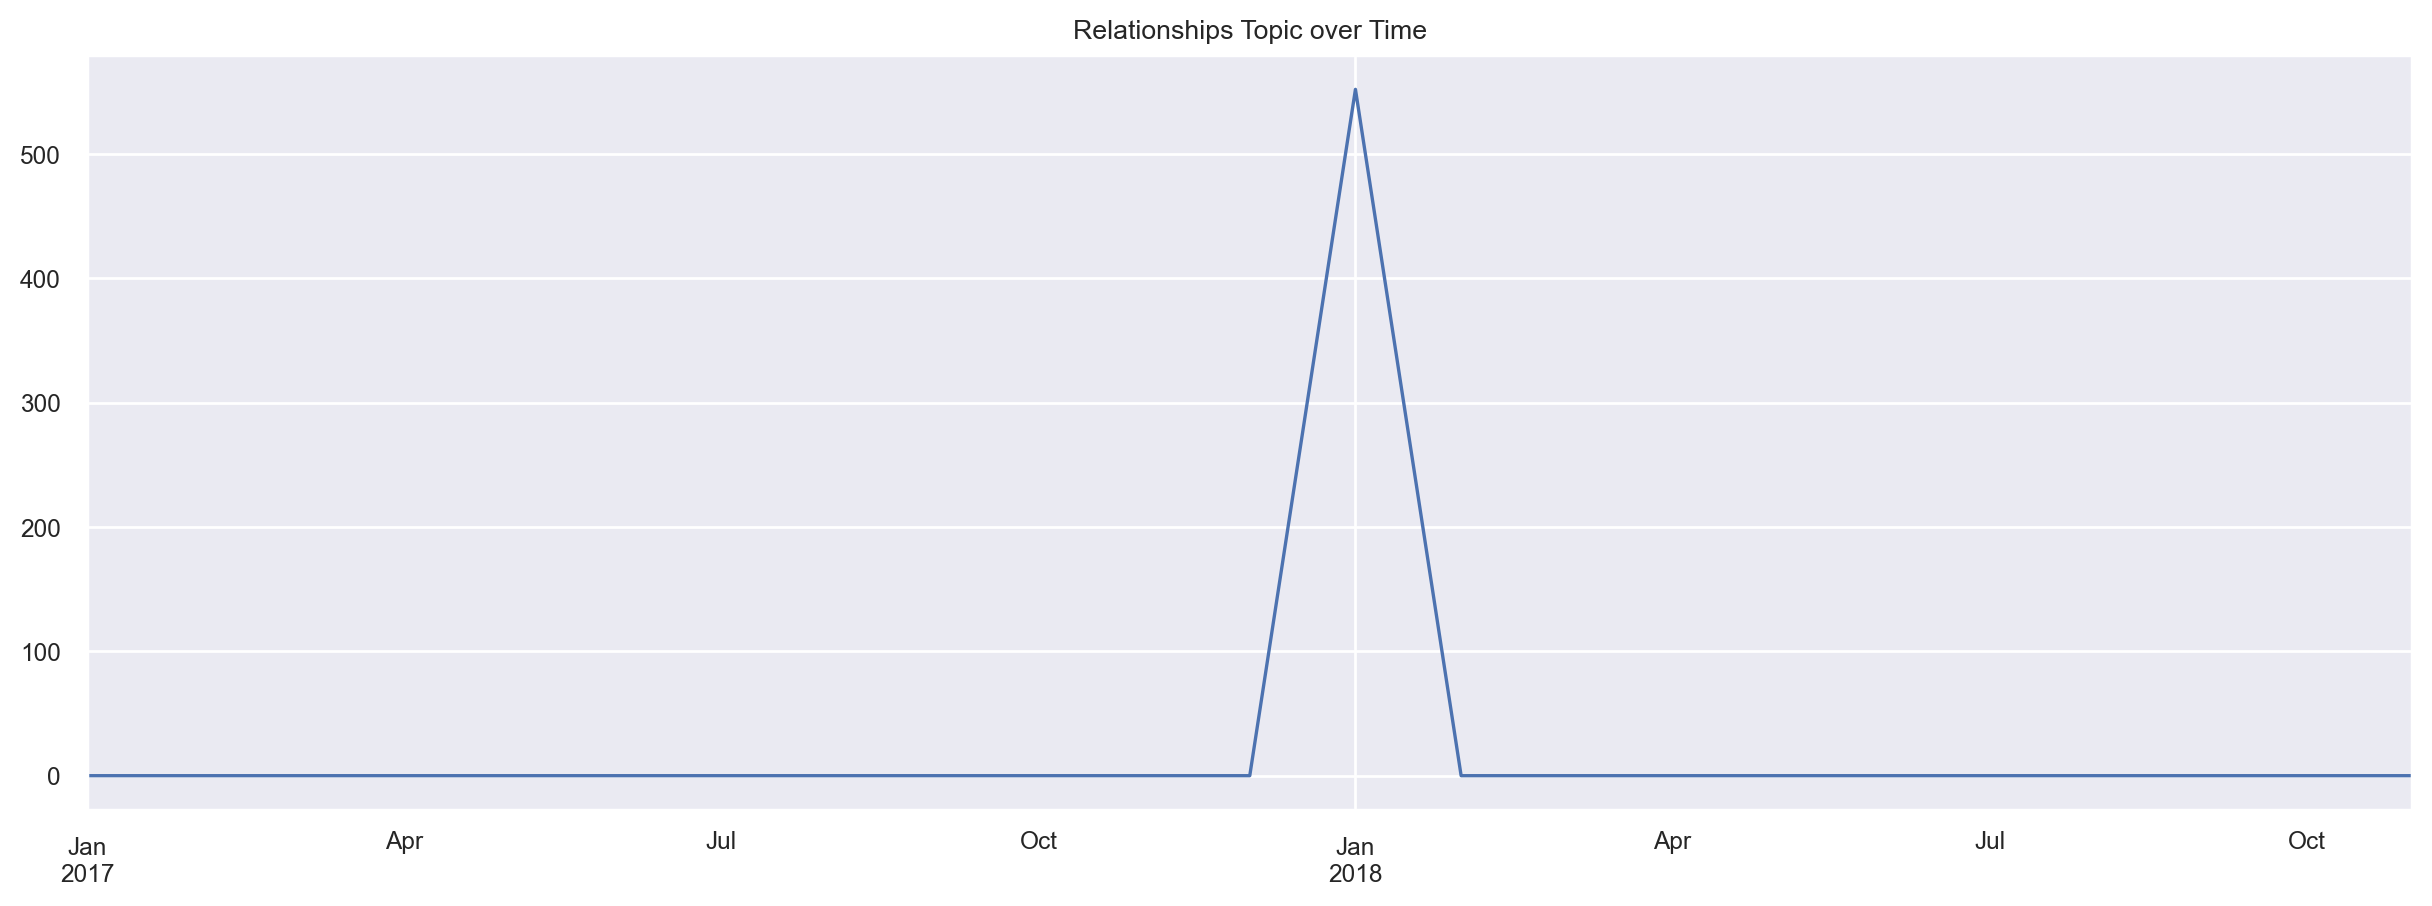

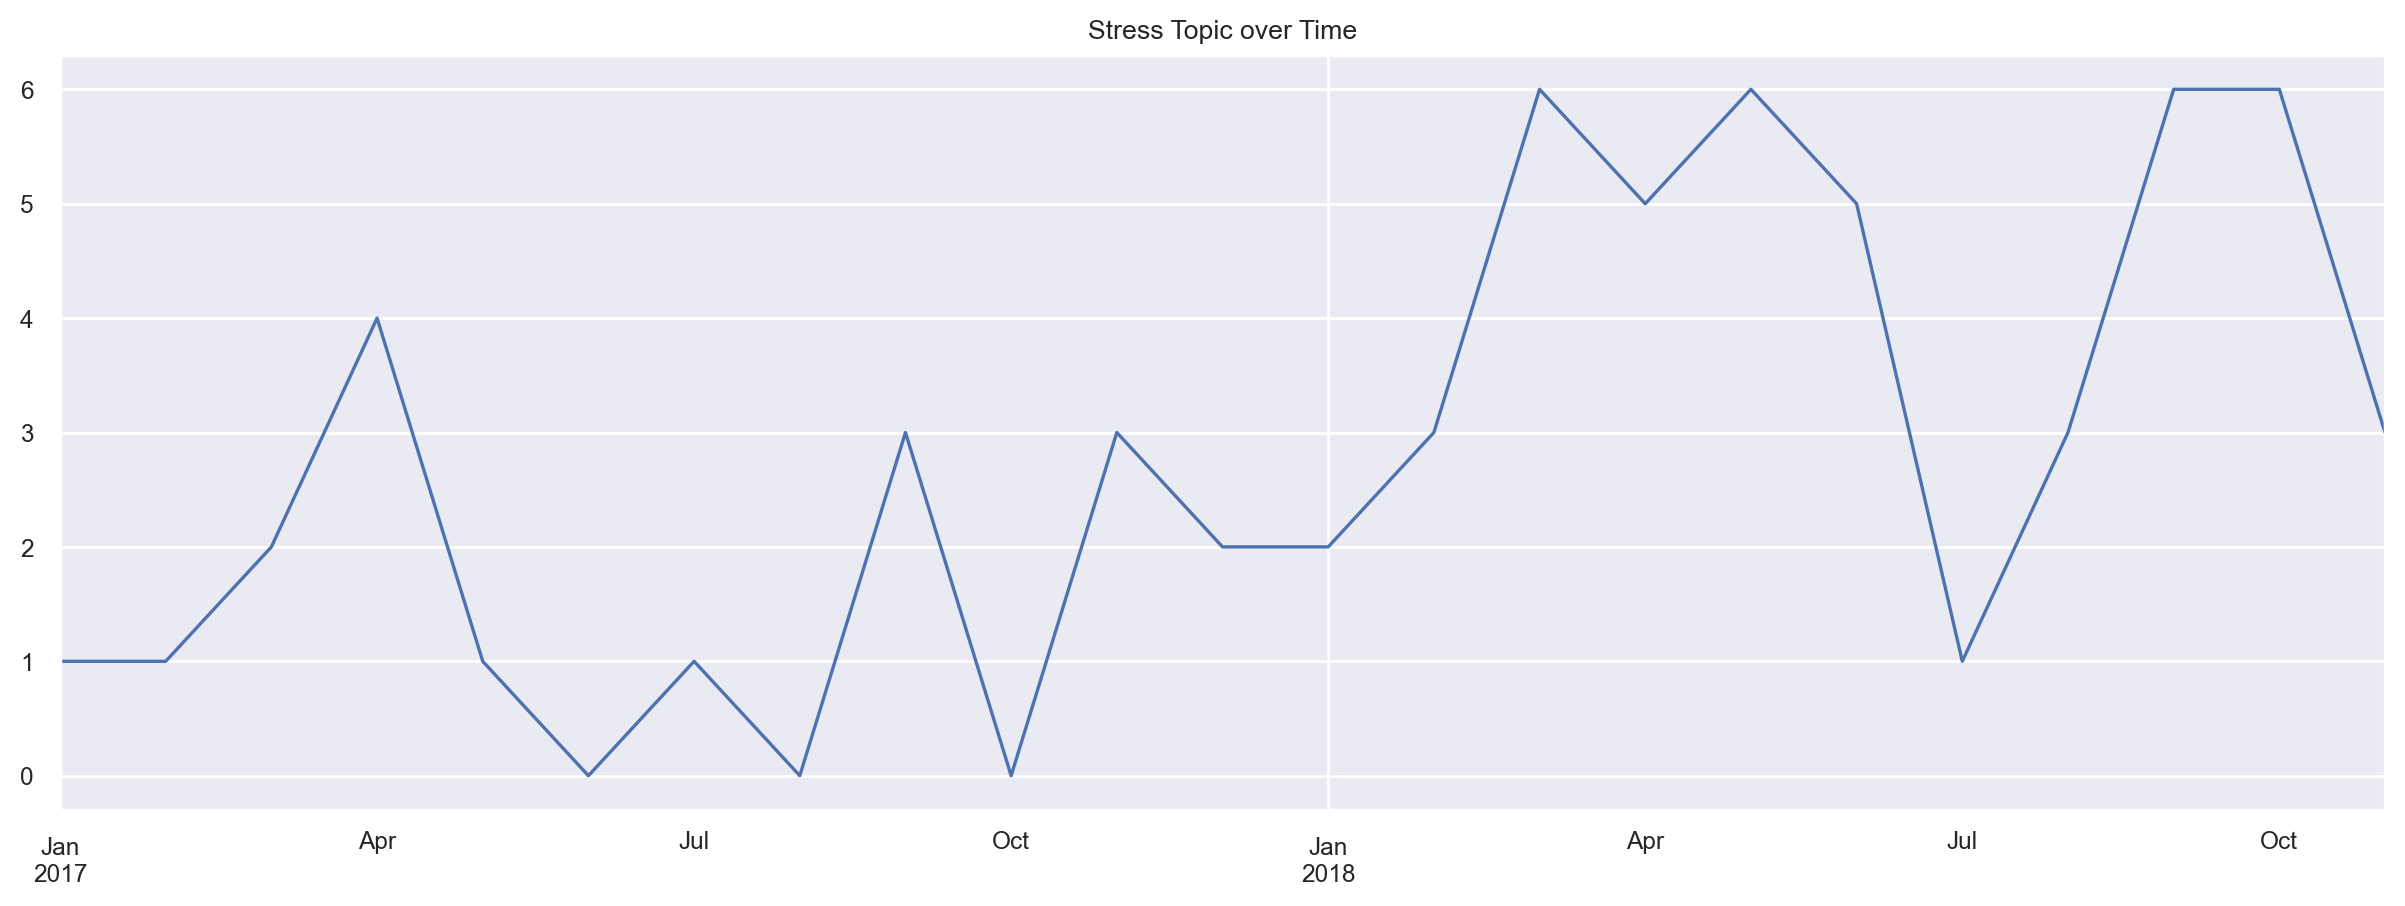

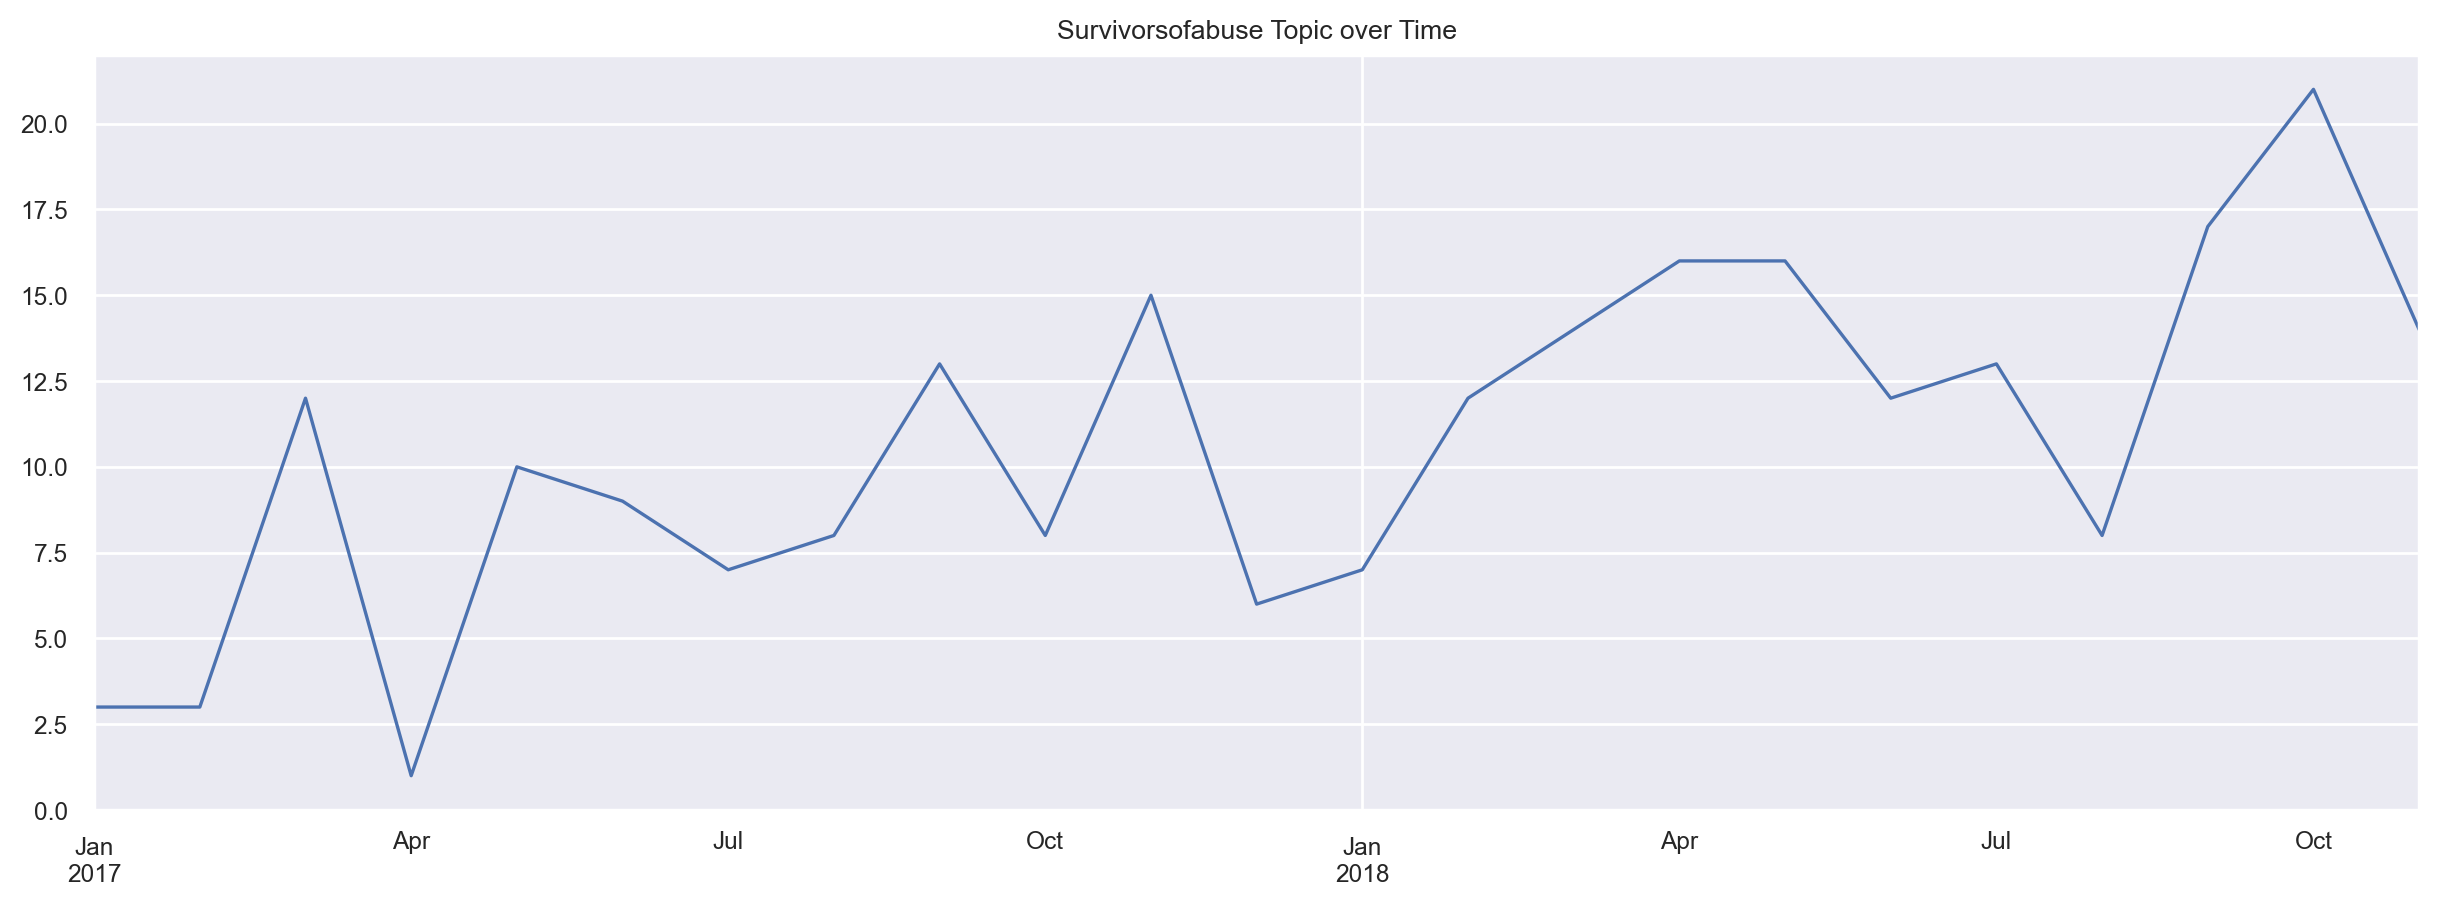

In [199]:
# let's plot the distinct total number of subreddit topics over time

for col in test_cols:
    plt.figure(figsize = (15, 5))
    plt.style.use('ggplot')
    sns.set(font_scale = 0.8)

    test_df[col].resample("M").sum().plot(kind = "line", linewidth = 1.2)
    plt.xlabel(None)

    plt.title(f'{col.title()} Topic over Time')
    plt.show()